# Final notebook

This notebook brings the showcase for the functions developed so far
and some interesting discussions.

Todo:

> Analysis for several years

> Predicting model

> Create the SQL databasis to save RAM (the *Several years* analysis
is quite ram consuming)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import time

In [2]:
### IMPORTING THE FUNCTIONS ###

from burning_given_year import burning_given_year as entire_country
from burning_specific_biome import burning_map_brazil as specific_biome_year
from piechart import pie_chart_year as piechart
from time_series import biome_plot as time_series
from several_years_biome import several_years_biome

# Single year analysis

## First part

### Number of burning events for an specific year

> The user enters the year and the app returns the number of burning events distribution
throughout the entire country. Since most people are not familiar with the biomes distribution,
a map containing it is shown as an auxiliary plot.

For instance, let's analyse the year of 2019

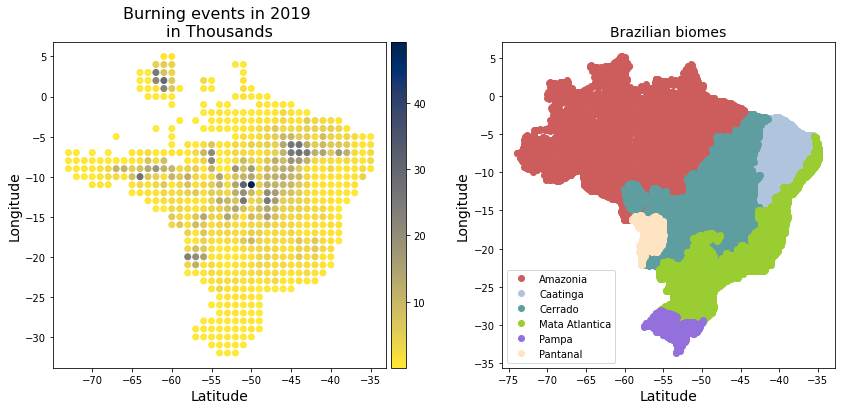

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

entire_country(2019, ax1, ax2, fig)

plt.show()

## Second part

### Distribution for an specific biome

> At this second part the user enters with an specific biome on top of what was entered
previously (the year) and gets a more complementary and quantitative for the interesting biome.

Now we consider the Pantanal, for sake of curiosity.

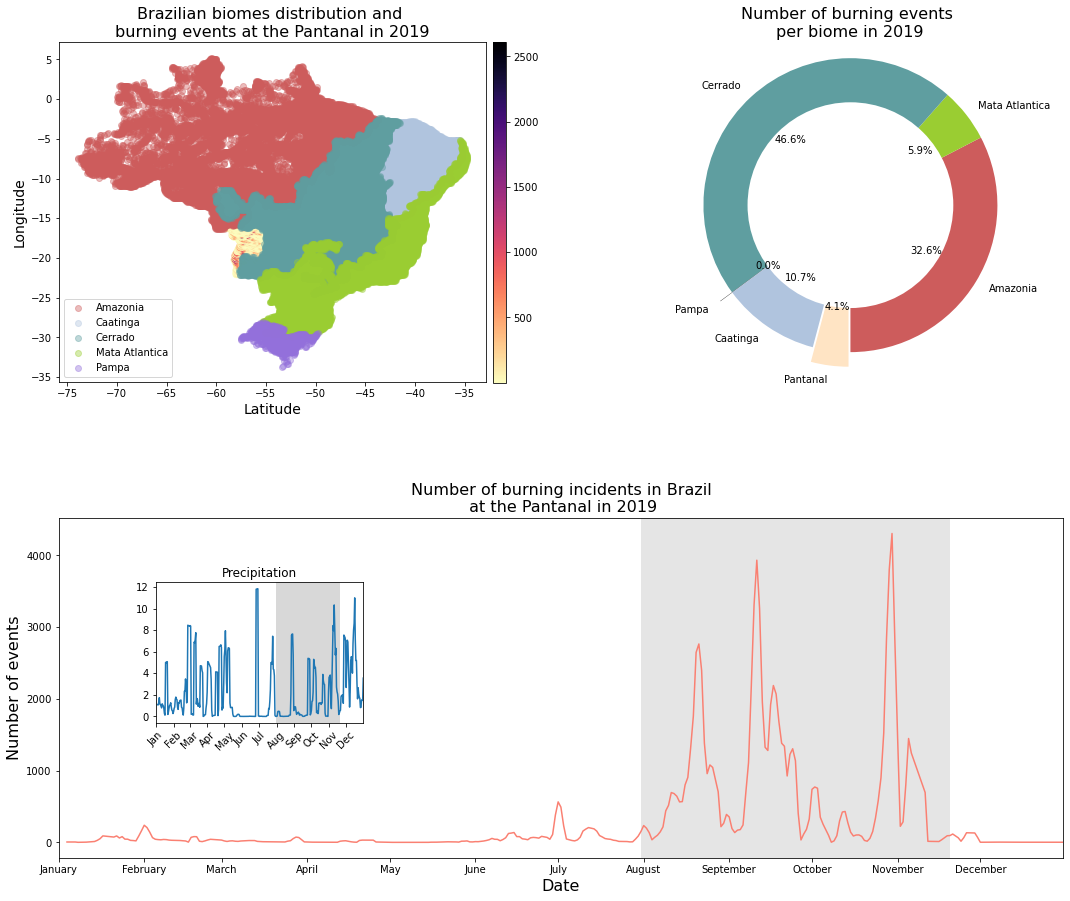

In [12]:
fig = plt.figure(figsize = (18,15))

gs = fig.add_gridspec(2, 2, hspace = 0.4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0,-1])
ax3 = fig.add_subplot(gs[1, :])
specific_biome_year(ax1, 2019, 'Pantanal', fig, cbar_location = [0.46, 0.565, 0.01, 0.315],)
piechart(ax2, 2019, 'Pantanal')
time_series(ax3, 2019, 'Pantanal', inset_location = [0.2, 0.25, .16, .13])

plt.show()

Another interesting and pertinent plot could be Amazonia, since it was a hot topic last year and even in 2020,
where the next president, Joe Biden, mentioned that could cut some commercial relationships with Brazil if we do not take severe measures against the blazing accidents.

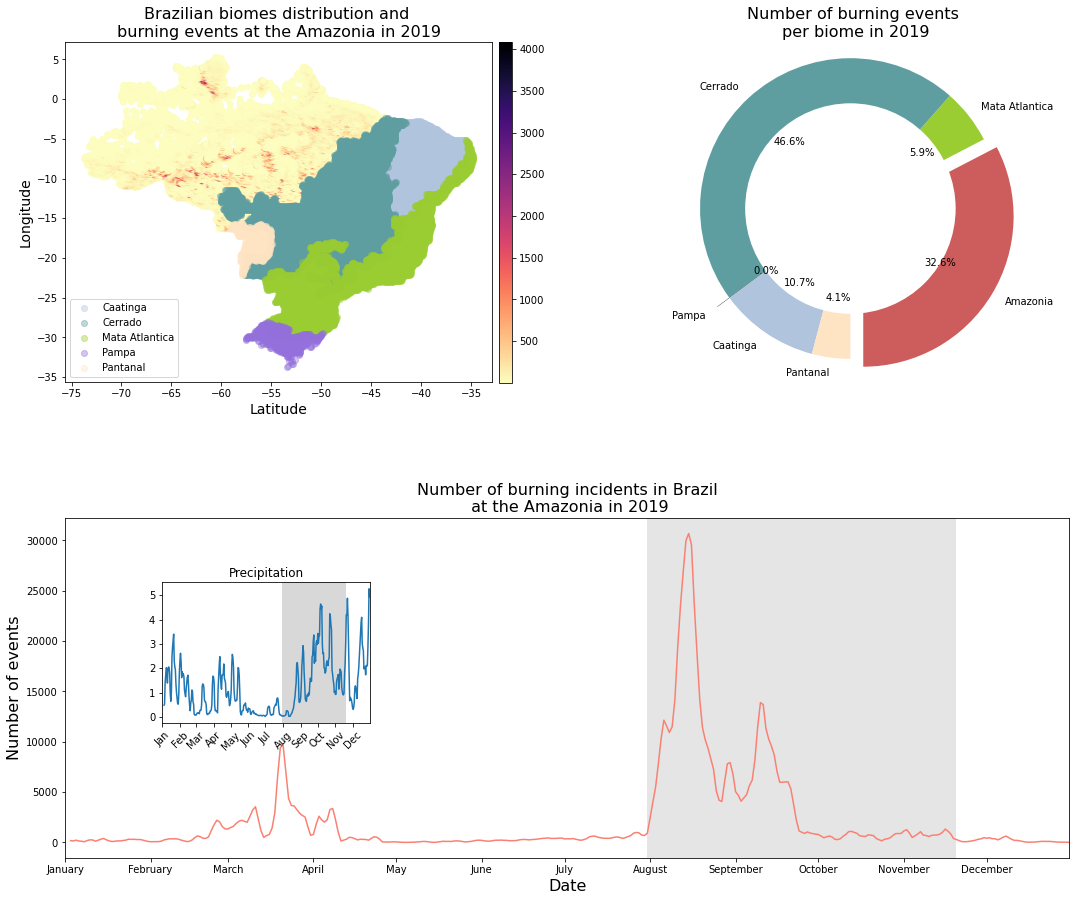

In [13]:
fig = plt.figure(figsize = (18,15))

gs = fig.add_gridspec(2, 2, hspace = 0.4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0,-1])
ax3 = fig.add_subplot(gs[1, :])
specific_biome_year(ax1, 2019, 'Amazonia', fig, cbar_location = [0.46, 0.565, 0.01, 0.315])
piechart(ax2, 2019, 'Amazonia')
time_series(ax3, 2019, 'Amazonia', inset_location = [0.2, 0.25, .16, .13])

plt.show()

# Several years analysis

At this part the user has the chance to choose among several years and make an analysis for
an specific biome for the chosen years. Since Pantanal was highly discussed last year (and Amazonia
this year, which might have serious impact even in the economy), let's take the chance to take a look on them

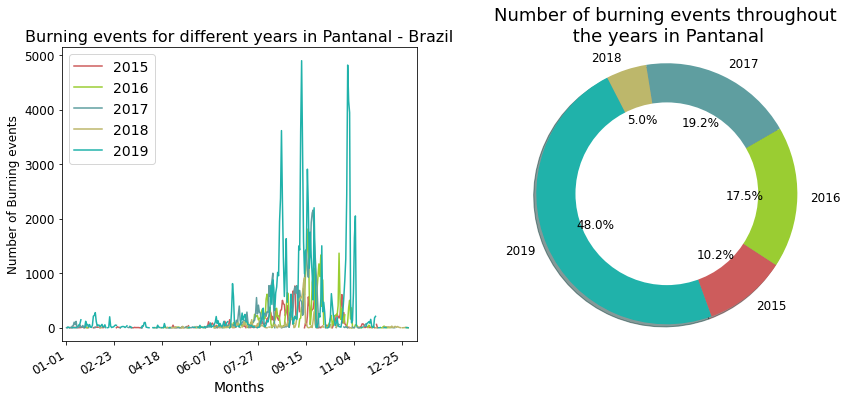

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

several_years_biome([2015, 2016, 2017, 2018, 2019], 'Pantanal', ax1, ax2, fig)

plt.show()

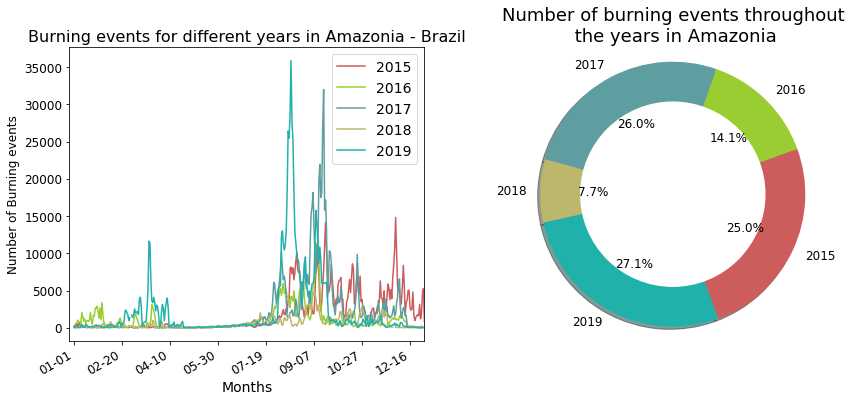

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

several_years_biome([2015, 2016, 2017, 2018, 2019], 'Amazonia', ax1, ax2, fig)

plt.show()

## Side note:

This notebook still has to improved in some minor aspects, like the dates in the *x-axis*,
regarding the several years analysis and the color chosen (and perhaps some extra ones).
There are still the prediction for future years to be done. However it gives a glimpse
on what the *burning events in Brazil* - app will be showing to the user.

The EDA and the data treatment can be found [here](https://github.com/ViniciusHenning/projects/blob/master/burned-brazil/burned-brazil.ipynb). There some conclusions/correlation among several years and biomes are made, however, most of the graphs are not in the final form yet.

An investigation regarding the spreading blazes across different biomes are made
and we put it here for sake of convenience.

## Discussion about the obtained results

> **Amazonia:** We observe that in Amazonia a slightly higher number of burning
events occurred in *2019* when compared to 2017. However, in *2019* we observe
a more pronounced peak within the period end-February and begin-April
(which didn't occur before). Also, we observe that the big peaks of burning events
(which start occurring two months after the starting of the dry season) started earlier
in that year. Perhaphs it is worth investing why (by analyzing the precipitation rate).

> **Cerrado:** We observe that it follows a similar trend that Amazonia does.
*2019* a higher number of burning events occurred ($\approx 6\%$) when compared to *2017*.
However the time-pattern throughout the years stayed the same.

> **Mata Atlantica:** We again observe a similar trend (there was no shift in the
burning season) however, the number of burning events started getting much higher.
We observe a number almost $70\%$ higher than in *2017*.

> **Caatinga:** In Caatinga we also observe a huge increament of burning events in *2019*.
Since Caatinga is a small biome (covered-area-wise) in between Mata Atlantica and
Cerrado, it might be worth plotting the burning events using latitude and longitude,
to check if it is happening  therein the proximity of Mata Atlantica (which also had
a huge increment in *2019*).

> **Pampa:** it is by far the biome less afected by the blaze catastrophe.

## Mata Atlantica

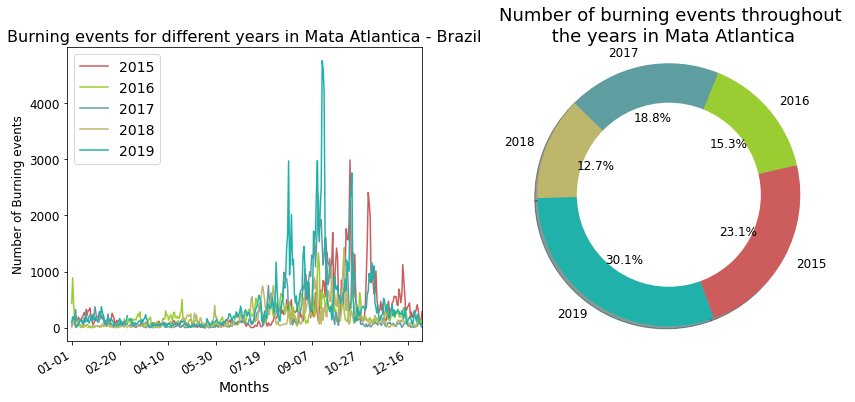

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

several_years_biome([2015, 2016, 2017, 2018, 2019], 'Mata Atlantica', ax1, ax2, fig)

plt.show()

## Caatinga

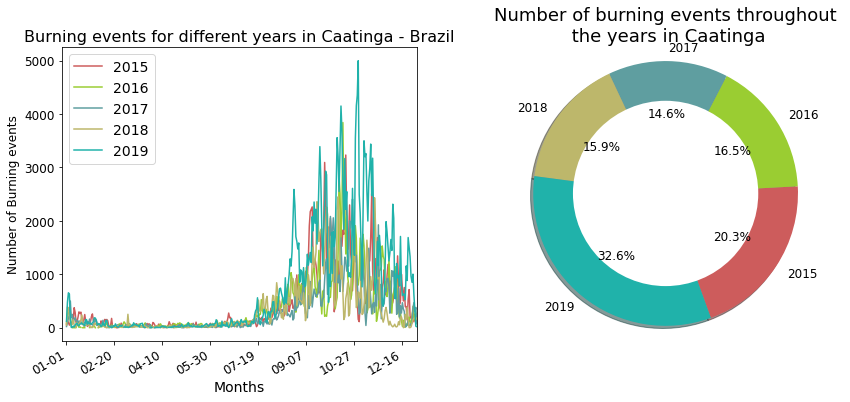

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

several_years_biome([2015, 2016, 2017, 2018, 2019], 'Caatinga', ax1, ax2, fig)

plt.show()

## The investigation itself

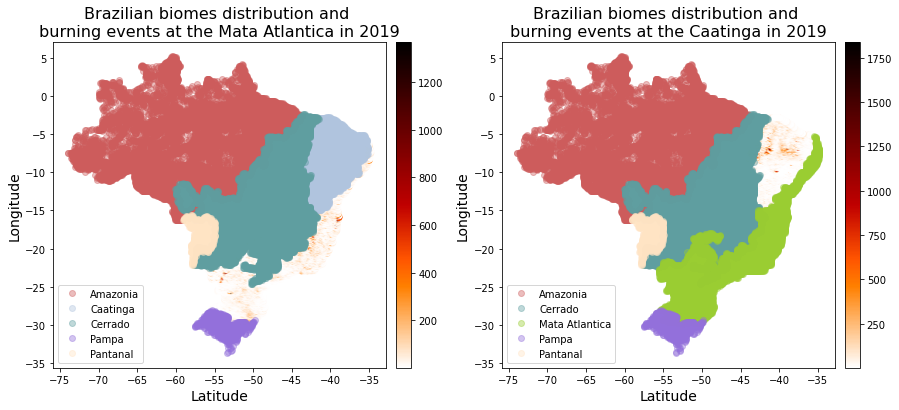

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6))

specific_biome_year(ax1, 2019, 'Mata Atlantica', fig, cbar_location = [0.465, 0.125, 0.015, 0.755])
specific_biome_year(ax2, 2019, 'Caatinga', fig, cbar_location = [0.91, 0.125, 0.015, 0.755])

plt.show()

We observe that the majority of blazes appeared closed to Cerrado rather than
Caatinga. It is worthwhile pointing out that there is indeed a set of burning
events happend in the very North of the Mata Atlantica biome, which is equivalent
to those nearby Cerrado. However, for the same latitude, the corresponding events
in Caatinga are pretty far apart and they are very unlikely correlated.

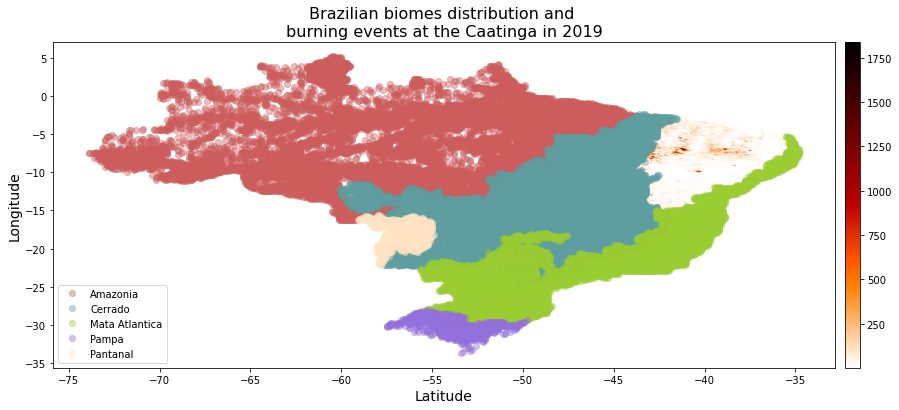

In [4]:
fig, ax = plt.subplots(figsize = (14,6))

specific_biome_year(ax, 2019, 'Caatinga', fig, cbar_location = [0.91, 0.125, 0.015, 0.755])

plt.show()

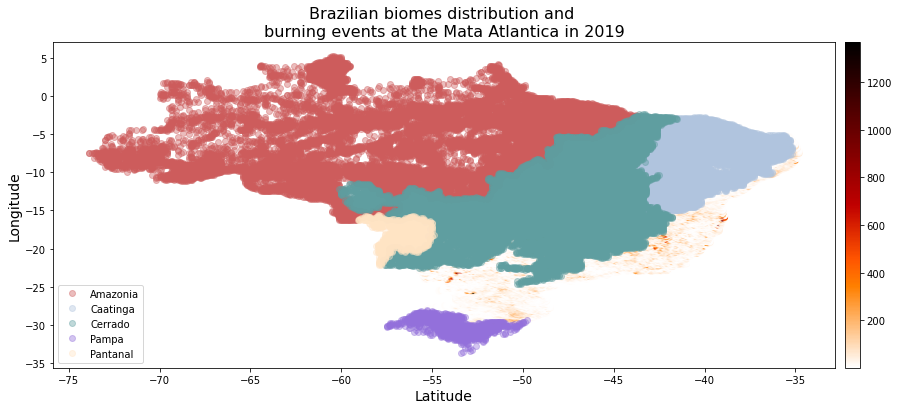

In [5]:
fig, ax = plt.subplots(figsize = (14,6))

specific_biome_year(ax, 2019, 'Mata Atlantica', fig, cbar_location = [0.91, 0.125, 0.015, 0.755])

plt.show()